# 训练脉冲神经网络

## 介绍
近几年，人们对训练脉冲神经网络（SNN）进行有意义的计算的兴趣激增。一方面，这种激增是由于更传统的、通常被认为在生物学上更合理的学习范式在创建解决有趣计算问题的功能神经网络方面取得的有限成就所推动的。深度神经网络在解决各种具有挑战性的计算问题方面取得了不可否认的成功，弥补了这一限制。这一成功既提高了标准，也提出了这一进展如何转化为脉冲神经网络的问题。

过去十年深度学习的兴起在很大程度上归功于GPU及其计算能力的提升、训练数据集的扩大，以及——或许最重要的是——对误差反向传播算法的特点和需求的理解进步。例如，我们现在知道必须避免梯度消失和爆炸问题，这一成就可以通过选择合理的非线性函数、适当的权重初始化和合适的优化器来实现。支持自动微分的强大软件包使得处理深度神经网络变得比以往更加轻松。这一发展提出了一个问题：我们能从深度学习和其工具中获得多少知识，并将其用于训练脉冲神经网络。尽管目前无法完全回答这些问题，但似乎我们可以从中学习很多。

在本教程中，我们使用[`brainstate`](https://brainstate.readthedocs.io/en/latest/)以及[Brain Dynamics Programming Ecosystem](https://ecosystem-for-brain-dynamics.readthedocs.io/en/latest/)中的工具，逐步构建一个脉冲神经网络。明确地说，我们的目标是构建解决（简单）现实世界问题的网络。为此，我们专注于分类问题，并结合上述的反向传播算法使用监督学习。为此，我们必须克服由脉冲本身的二元性质引起的梯度消失问题。

在本教程中，我们将首先展示如何将一个简单的前向传播的基于泄露整合发放（LIF）神经元和基于电导的突触脉冲神经网络（SNN）形式化地映射到离散时间循环神经网络 (RNN)。我们将利用这一公式来解释为什么在脉冲时梯度会消失，并展示一种缓解该问题的方法。具体来说，我们将引入代理梯度，并提供在Brainstate中如何实现它们的实际示例。

## 将LIF神经元映射到RNN动力学

计算神经科学中网络模拟的事实上的标准神经元模型是LIF神经元模型，它通常被正式写成微分形式的时间连续动力系统：
$$\tau_\mathrm{mem} \frac{\mathrm{d}U_i^{(l)}}{\mathrm{d}t} = -(U_i^{(l)}-U_\mathrm{rest}) + RI_i^{(l)}$$
其中 $U_i$ 是第 $l$ 层神经元 $i$ 的膜电位，$U_\mathrm{rest}$ 是静息电位，$\tau_\mathrm{mem}$ 是膜时间常数，$R$ 是输入电阻，$I_i$ 是输入电流。膜电位 $U_i$ 表征每个神经元的隐藏状态，并且重要的是，它不会直接传递给下游神经元。然而，当神经元的膜电压超过阈值 $\vartheta$ 时，神经元会在时间 $t$ 发射动作电位或脉冲。发射脉冲后，神经元的膜电压被重置 $U_i \rightarrow U_\mathrm{rest}$。我们写作
$$S_i^{(l)}(t)=\sum_{k \in C_i^l} \delta(t-t_j^k)$$ 
表示脉冲序列（即神经元 $i$ 在第 $l$ 层发射的所有脉冲 $C_i^l$ 的总和）。这里 $\delta$ 是狄拉克δ函数，$t_i^k$ 是神经元的相关发射时间。

脉冲沿着轴突传播并在连接的神经元中产生突触后电流。使用上述形式，我们可以写作
$$\frac{\mathrm{d}I_i}{\mathrm{d}t}= -\frac{I_i(t)}{\tau_\mathrm{syn}} + \sum_j W_{ij} S_j^{(0)}(t) + \sum_j V_{ij} S_j^{(1)}(t)$$
其中我们引入了突触权重矩阵 $W_{ij}$（前馈），$V_{ij}$（递归），以及突触衰减时间常数 $\tau_\mathrm{syn}$。

为了与RNN明显联系起来，我们现在将上述方程表达为离散时间形式。为了简洁起见，我们切换到自然单位 $U_\mathrm{rest}=0$，$R=1$，和 $\vartheta=1$。我们的论点不受此选择的影响，所有结果都可以重新缩放到物理单位。为了突出脉冲的非线性特征，我们首先注意到可以设置
$$S_i^{(l)}(t)=\Theta(U_i^{(l)}(t)-\vartheta)$$
其中 $\Theta$ 表示赫维赛德阶跃函数。

假设一个小的模拟时间步长 $\Delta_t>0$，我们可以通过以下方式近似突触动力学：
$$I_i^{(l)}(t+1) = \alpha I_i^{(l)}(t) + \sum_j W_{ij} S_j^{(l-1)}(t) +\sum_j V_{ij} S_j^{(l)}(t)$$
其中常数 $\alpha=\exp\left(-\frac{\Delta_t}{\tau_\mathrm{syn}} \right)$。此外，膜动力学可以写成
$$U_i^{(l)}(t+1) = \underbrace{\beta U_i^{(l)}(t)}_{\mathrm{leak}} + \underbrace{I_i^{(l)}(t)}_{\mathrm{input}} -\underbrace{S_i^{(l)}(t)}_{\mathrm{reset}}$$
其中输出 $S_i(t) = \Theta(U_i(t)-1)$ 和常数 $\beta=\exp\left(-\frac{\Delta_t}{\tau_\mathrm{mem}}\right)$。注意方程右侧的不同项，它们分别负责：i) 泄漏，ii) 突触输入，和 iii) 脉冲重置。

这些方程可以简洁地总结为具有特定连接结构的RNN的计算图。

<p align="center">
    <img src="https://raw.githubusercontent.com/surrogate-gradient-learning/spytorch/refs/heads/master/notebooks/figures/snn_graph/snn_graph.png" alt="snn_graph"/>
</p>


时间从左到右流动。输入在每个时间步从图的底部进入网络（$S_i^{(0)}$）。这些输入依次影响突触电流 $I_i^{(1)}$，膜电位 $U_i^{(1)}$，最后是脉冲输出 $S_i^{(1)}$。此外，动态量直接输入到未来的时间步。为了清晰起见，在图中省略了索引 $i$。

计算图展示了一个称为时间展开的概念，它强调了深度神经网络和循环神经网络之间的对偶性，后者只不过是时间上的深度网络（具有绑定权重）。由于这一事实，我们可以使用时间反向传播（BPTT）来训练RNN。我们将在后面讨论由脉冲非线性的二元特性引起的问题。现在，让我们首先在Brainstate中实现上述动力学的三层脉冲神经网络。

## 示例

让我们从一个简单的多层网络模型开始，该模型具有单个隐藏层，如下所示。为了简单起见，我们暂时不使用递归连接 $V$，记住如果需要，可以在以后添加它们。

<p align="center">
    <img src="https://raw.githubusercontent.com/surrogate-gradient-learning/spytorch/refs/heads/master/notebooks/figures/mlp_sketch/mlp_sketch.png" alt="snn_graph"/>
</p>

我们首先导入所需的库。

In [19]:
import time

import braintools as bts
import brainunit as u
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import brainstate as bst

In [20]:
nb_inputs  = 100
nb_hidden  = 4
nb_outputs = 2

正如我们上面所看到的，我们实际上是在模拟一个RNN。因此，我们必须为一定数量的时间步长模拟我们的神经元。我们将使用1毫秒的时间步长，并且我们希望模拟我们的网络200个时间步长。

In [21]:
time_step = 1 * u.ms
bst.environ.set(dt=time_step)
nb_steps  = 200

为了利用并行性，我们将设置代码以处理数据批次，就像通常对以监督方式训练的神经网络所做的那样。
为此，我们在这里指定一个批次大小。

In [22]:
batch_size = 256

在做出这些基本设计选择之后，我们现在可以开始构建实际的网络了

### A simple synthetic dataset 

We start by generating some random spiking data set, which we will use as input to our network. In the beginning, we will work with a single batch of data. It will be straight forward to expand later what we have learned to larger datasets.

Suppose we want our network to classify a set of different sparse input spike trains into two categories. 

To generate some synthetic data, we fill a tensor of (batch_size x nb_steps x nb_inputs) with random uniform numbers between 0 and 1 and use this to generate our input dataset:

In [23]:
freq = 5 * u.Hz
x_data = bst.random.rand(nb_steps, batch_size, nb_inputs) < freq * bst.environ.get_dt()

If the plot the spike raster of the first input pattern, this synthetic dataset looks as follows.

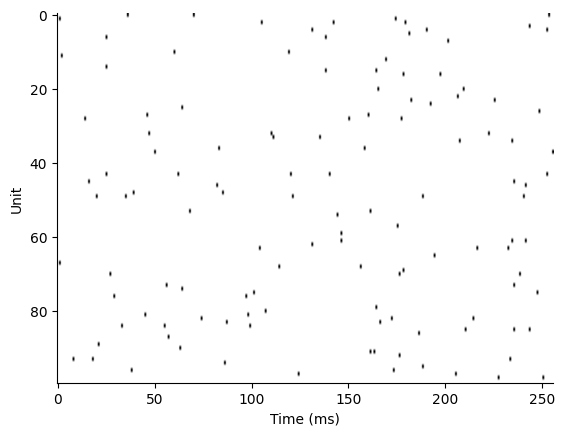

In [24]:
data_id = 0
plt.imshow(x_data[data_id].transpose(), cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()

Next, we assign a random label of 0 or 1 to each of our input patterns. Our network's task will be to differentiate these patterns.

In [25]:
y_data = u.math.asarray(bst.random.rand(batch_size) < 0.5, dtype=int)

Note that there is no structure in the data (because it is entirely random). Thus we won't worry about generalization now and only care about our ability to overfit these data with the spiking neural network we are going to build in a jiffy.

### Setup of the spiking network model

Now is the time to implement our LIF neuron model in discrete time.
We will first do this step by step before we wrap all the steps into a function later on.
But first, we fix several model constants such as the membrane and the synaptic time constant. Moreover, we define some essential variables, including our $\alpha$ and $\beta$ as described above. We do this now because we will use some of these variables to scale our weights to meaningful ranges.

In [26]:
tau_mem = 10 * u.ms
tau_syn = 5 * u.ms

alpha = float(u.math.exp(-bst.environ.get_dt() / tau_syn))
beta  = float(u.math.exp(-bst.environ.get_dt() / tau_mem))

Now we set up our weight matrices, which connect the input and the hidden layer, as well as the matrix connecting the hidden layer with the output layer. Moreover, we initialize these weights randomly from a normal distribution. Note that we scale the variance with the inverse square root of the number of input connections. Moreover, for the sake of simplicity, we ignore Dale's law in this tutorial. Thus weights can be either excitatory or inhibitory. This choice is prevalent in artificial neural networks.

In [ ]:
weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

w1 = u.math.empty((nb_inputs, nb_hidden))

w2 = u.math.empty((nb_hidden, nb_outputs))

In [27]:
def plot_voltage_traces(mem, spk=None, dim=(3, 5), spike_height=5, show=True):
    fig, gs = bts.visualize.get_figure(*dim, 3, 3)
    if spk is not None:
        mem[spk > 0.0] = spike_height
    if isinstance(mem, u.Quantity):
        mem = mem.to_decimal(u.mV)
    for i in range(np.prod(dim)):
        if i == 0:
            a0 = ax = plt.subplot(gs[i])
        else:
            ax = plt.subplot(gs[i], sharey=a0)
        ax.plot(mem[:, i])
    if show:
        plt.show()